In [1]:
import sys
print(sys.version)
import tensorflow as tf
print(tf.__version__)

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:27:36) [GCC 11.2.0]


2025-01-09 22:24:38.276693: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 22:24:38.304148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 22:24:38.322254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 22:24:38.327305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 22:24:38.341828: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [3]:
import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import sklearn
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

2025-01-09 14:27:39.407322: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 14:27:39.429640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 14:27:39.447620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 14:27:39.452620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 14:27:39.467113: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [3]:
# ### Define the path where the images are located and where we want to create the class directories
# image_folder = '/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/original_dataset'
# csv_file = '/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/labels.csv'

# # Read the CSV file using pandas
# df = pd.read_csv(csv_file)

# # Extract the class labels from the CSV file
# # Assuming the first 4 columns are headers, and the next 3 rows correspond to the images
# classes = df.iloc[0:, 5:].values  # The class names for each image (after the header row)
# # List of class names (from the CSV structure)
# # Find unique values in the 'column_name' column
# class_names = df['label'].unique()

# # Ensure that class directories exist
# for class_name in class_names:
#     class_dir = os.path.join(image_folder, class_name)
#     if not os.path.exists(class_dir):
#         os.makedirs(class_dir)

# # Loop over all images 
# for i in tqdm(range(25773)):  # 25773 rows for 10 images each
#     for j in range(10):  # 10 images per row
#         image_filename = f"{i}_{j}.jpg"  # Assuming images are named like 0_0.jpg, 0_1.jpg, etc.
#         image_path = os.path.join(image_folder, image_filename)

#         # Find the class for this image based on the CSV
#         class_label = classes[i][0]
#         #print(class_label)
        
#         # Determine the target class directory
#         target_dir = os.path.join(image_folder, class_label)

#         # Move the image to the correct class directory
#         if os.path.exists(image_path):
#             shutil.move(image_path, os.path.join(target_dir, image_filename))
#         else:
#             print(f"Warning: {image_filename} not found in {image_folder}")

# print("Images have been successfully organized.")

In [20]:
# Read the CSV file
df = pd.read_csv("/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/labels.csv")

# Find unique values in the 'column_name' column
unique_values = df['label'].unique()

print(len(unique_values))
print(unique_values)

18
['metamyelocyte' 'myelocyte' 'seg_neutrophil' 'band_neutrophil'
 'lymphocyte' 'monocyte' 'immature_wbc' 'eosinophil' 'artifact' 'basophil'
 'abnormal_lymphocyte' 'unk_wbc' 'smudge' 'n_rbc' 'g_plt' 'agg_plt'
 'blast' 'promyelocyte']


In [2]:
# def create_dataset(img_folder, label):
#     stacked_images = []
#     image_batch = []  
#     for file in tqdm(os.listdir(img_folder)):
#         image_path= os.path.join(img_folder, file)
#         image= cv2.imread(image_path)[:,:,::-1]
#         image=cv2.resize(image, (128, 128),interpolation = cv2.INTER_AREA)   
#         # image [image<0] = 0
#         img_nor = image / 255.0  ##np.max(image)
#         image=np.array(img_nor, dtype = np.float32)
#         image_batch.append(image)
#         if len(image_batch) == 10:  ##stack_size=10
#             #stacked_images.append(image_batch)
#             stacked_images.append(np.array(image_batch, np.float32))
#             image_batch = []          
#     stacked_images = np.array((stacked_images), np.float32)
#     train, test = train_test_split(stacked_images, test_size=0.1, random_state=7)
#     train_images = train.reshape(-1, 128, 128, 3)
#     train_label = np.full(len(train_images), label)
#     test_images = test.reshape(-1, 128, 128, 3)
#     test_label = np.full(len(test_images), label)
#     return train_images, train_label, test_images, test_label

# def complete_data(full_datapath):
#     label = 0
#     for dir_name in os.listdir(full_datapath):
#         data_path = os.path.join(full_datapath, dir_name)
#         #print(data_path)
#         print(f"class {label} is associated with directory: {dir_name}")
#         train_images, train_label, test_images, test_label = create_dataset(data_path, label)
#         label+=1
#         if label == 1:
#             train_data = train_images
#             train_class = train_label
#             test_data = test_images
#             test_class = test_label
#         else:
#             train_data = np.concatenate((train_data, train_images))
#             train_class = np.concatenate((train_class, train_label))
#             test_data = np.concatenate((test_data, test_images))
#             test_class = np.concatenate((test_class, test_label))
#             del train_images
#             del train_label
#             del test_images
#             del test_label
#     return train_data, train_class, test_data, test_class
    
# x_train, y_train, x_test, y_test = complete_data(r'/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/original_dataset')
# print(f"x_training data shape: {x_train.shape} and test data shape: {x_test.shape}: ")
# print(f"x_training label shape: {y_train.shape} and test label shape: {y_test.shape}: ")

# y_train_encoded = to_categorical(y_train)
# y_test_encoded = to_categorical(y_test)

# print(y_train_encoded.shape)
# print(y_test_encoded.shape)

In [4]:
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_data.npy', x_train)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_label.npy', y_train_encoded)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_data.npy', x_test)
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_label.npy', y_test_encoded)

In [2]:
## for train and test with 90:10 ratio analysis load them ##

# x_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_data.npy')
# y_train_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/train_label.npy')
x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_data.npy')
y_test_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/test_label.npy')

In [34]:
# # Reshape into 10 groups, each containing 10 stacked 2D images
# num_groups = len(x_test) // 10
# #stacked_images = x_test.reshape(num_groups, 10, 128, 128, 3)  # Shape: (10, 10, height, width, 3)
# stacked_labels = y_test_encoded.reshape(num_groups, 10, 16)  
# # Example: Accessing the first 3D group
# print("Stacked 3D images shape:", stacked_labels.shape)

Stacked 3D images shape: (2549, 10, 16)


<Figure size 1000x500 with 0 Axes>

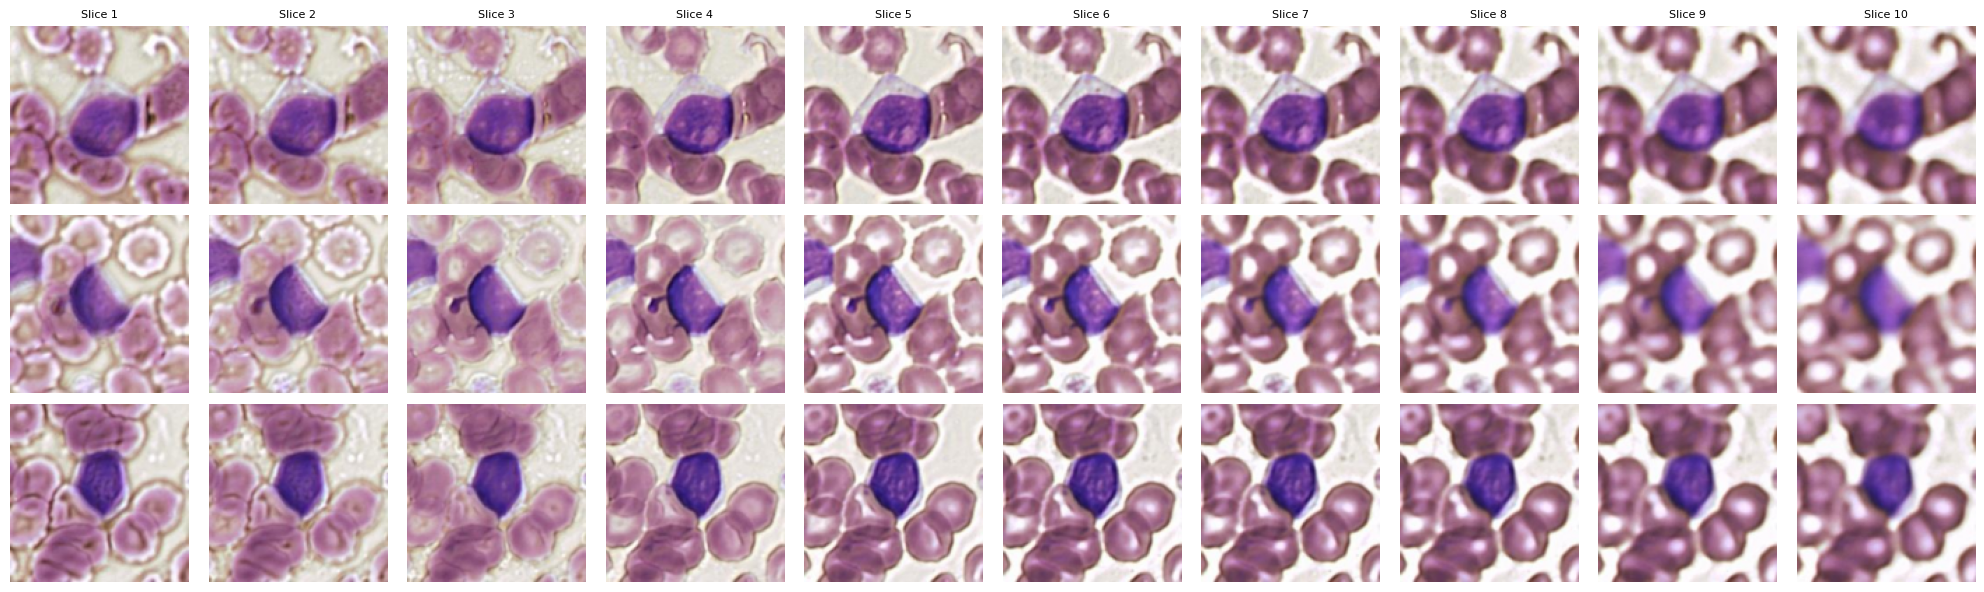

In [32]:
# plt.figure(figsize=(10,5))
# groups_to_plot = [0, 1, 2]  # Adjust indices as needed
# fig, axes = plt.subplots(len(groups_to_plot), 10, figsize=(20, 6))
# for row, group_index in enumerate(groups_to_plot):
#     for col in range(10):  # 10 slices in each group
#         ax = axes[row, col] if len(groups_to_plot) > 1 else axes[col]
#         ax.imshow(stacked_images[group_index, col])  # Display the slice (2D color image)
#         ax.axis('off')  # Hide axis for clarity
#         ax.set_title(f"Slice {col+1}", fontsize=8) if row == 0 else None  # Title only on first row

# # Add overall titles and spacing
# plt.tight_layout()
# plt.show()

In [3]:
# for cross validation analysis load them ##
def split_dataset(x_train, y_train_encoded, num_splits=5):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    num_groups = len(x_train) // 10
    x_train = x_train.reshape(num_groups, 10, 128, 128, 3)  # Shape: (groups, 10, height, width, 3)
    y_train_encoded = y_train_encoded.reshape(num_groups, 10, 16)  
    
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    y_train = np.argmax(y_train_encoded, axis=2)
    y_train = np.max(y_train, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_train, y_train)):
        x_split = x_train[split_indices]
        y_split = y_train[split_indices]
        splits.append((x_split, y_split))
    
    return splits

x_all = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/all_data.npy')
y_all_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/all_label.npy')

splits = split_dataset(x_all, y_all_encoded, num_splits=5)

for i, (x_split, y_split) in enumerate(splits):
    print(f"Split {i+1}: {len(x_split)} samples, Classes: {np.unique(y_split)}")

5it [00:13,  2.63s/it]

Split 1: 5085 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 2: 5084 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 3: 5084 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 4: 5084 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 5: 5084 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [14]:
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f1_data.npy', splits[0][0])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f2_data.npy', splits[1][0])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f3_data.npy', splits[2][0])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f4_data.npy', splits[3][0])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f5_data.npy', splits[4][0])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f1_label.npy', splits[0][1])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f2_label.npy', splits[1][1])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f3_label.npy', splits[2][1])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f4_label.npy', splits[3][1])
# np.save('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f5_label.npy', splits[4][1])

In [ ]:
# f1_data = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f1_data.npy')
# f2_data = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f2_data.npy')
# f3_data = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f3_data.npy')
# f4_data = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f4_data.npy')
# f5_data = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f5_data.npy')
# f1_label = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f1_label.npy')
# f1_label = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f2_label.npy')
# f1_label = p.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f3_label.npy')
# f1_label = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f4_label.npy')
# f1_label = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/f5_label.npy')

In [35]:
def slice_3d_color_images_and_labels(images, labels, num_slices=10):
    
    if images.ndim != 5:
        raise ValueError("Input images must be a 5D array of shape (N, D, H, W, C).")
    if labels.ndim != 1:
        raise ValueError("Labels must be a 1D array of shape (N,).")
    if images.shape[0] != labels.shape[0]:
        raise ValueError("Number of images and labels must match.")

    N, D, H, W, C = images.shape
    slice_indices = np.linspace(0, D - 1, num=num_slices, dtype=int)
    
    #sliced_images = []
    repeated_labels = []

    for i in tqdm(range(N)):
        for idx in slice_indices:
            #sliced_images.append(images[i, idx, :, :, :])  # Take a 2D slice
            repeated_labels.append(labels[i])             # Repeat the corresponding label

    ### Convert to numpy arrays
    #sliced_images = np.array(sliced_images)
    repeated_labels = np.array(repeated_labels)

    return repeated_labels  ##sliced_images, repeated_labels

In [42]:
# x_train = np.concatenate((splits[0][0], splits[1][0], splits[2][0], splits[3][0]))
# x_test = splits[4][0]
# y_train = np.concatenate((splits[0][1], splits[1][1], splits[2][1], splits[3][1]))
# y_test = splits[4][1]

In [43]:
# y_train = slice_3d_color_images_and_labels(x_train, y_train, num_slices=10)
# y_test = slice_3d_color_images_and_labels(x_test, y_test, num_slices=10)
# y_train_encoded = to_categorical(y_train)
# y_test_encoded = to_categorical(y_test)
# x_train = x_train.reshape(-1, 128, 128, 3)
# x_test = x_test.reshape(-1, 128, 128, 3)

100%|███████████████████████████████████████████████████████████████████████████| 5084/5084 [00:00<00:00, 557136.48it/s]


In [2]:
x_train = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/first fold/f1_training_data.npy')
y_train_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/first fold/f1_training_label_encoded.npy')
# x_test = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/first fold/f1_test_data.npy')
# y_test_encoded = np.load('/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/5 folds/first fold/f1_test_label_encoded.npy')

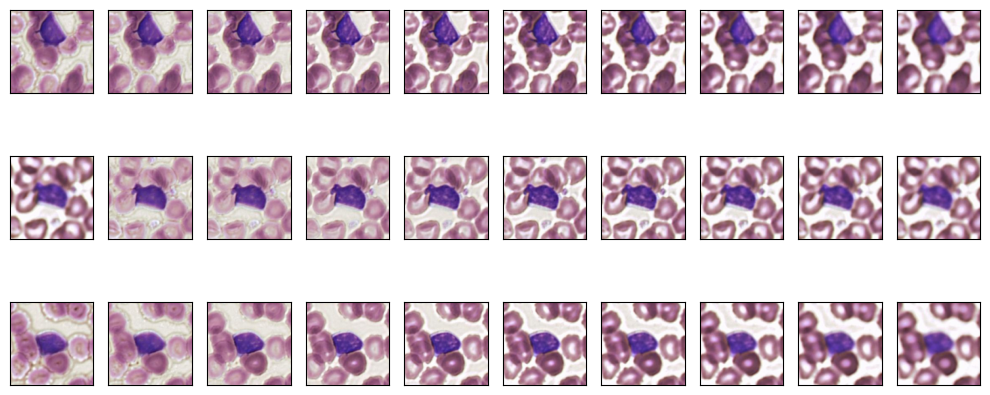

In [37]:
plt.figure(figsize=(10,5))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.grid(False)
    plt.imshow((x_test[i] * 255).astype(np.uint8))
plt.show()

In [2]:
def cbam_block(cbam_feature, ratio=16):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521."""

    cbam_feature = channel_attention(cbam_feature, ratio)
    #cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def channel_attention(input_feature, ratio=16):

    channel = input_feature.shape[-1] # if channel last, axis = -1 or if channel first then axis = 1
    i_shape = input_feature.shape[1]  #shape of input 

    shared_layer_one = Conv2D(channel//ratio, 1, activation='relu', use_bias=False)
    shared_layer_two = Conv2D(channel, 1, use_bias=False)

    avg_pool = AveragePooling2D(pool_size=(i_shape, i_shape), strides=i_shape, padding='same')(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = MaxPooling2D(pool_size=(i_shape, i_shape), strides=i_shape, padding='same')(input_feature)  
    max_pool = shared_layer_one(max_pool)  
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    ##if channel first then use this
    #cbam_feature = Permute((4, 1, 2, 3))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    channel = input_feature.shape[-1]  # if channel last, axis = -1 or if channel first then axis = 1
    #if channel first then use this
    #cbam_feature = Permute((2,3,4,1))(input_feature)

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)  #(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)  #(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1, kernel_size=kernel_size, strides=1, padding='same',
                    activation=None, kernel_initializer='he_normal', use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1
    cbam_feature = tf.sigmoid(cbam_feature, 'sigmoid')
    
    #if channel first then use this
    #cbam_feature = Permute((4, 1, 2, 3))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])
    
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
        x = cbam_block(x)
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x

def DenseNet121(input_shape=(128, 128, 3), num_classes=8):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    #x = cbam_block(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    #x = cbam_block(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    #x = cbam_block(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    #x = cbam_block(x)

    x = dense_block(x, 16, 32)
    #x = cbam_block(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = DenseNet121()
#model.summary()

NameError: name 'Input' is not defined

In [4]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip((y_true) * (y_pred), 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives + K.epsilon())
    
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1))) 
    return true_negatives / (possible_negatives + K.epsilon())

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
    
LR = 0.001
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=10000,
    decay_rate=0.5) #should be < 1, otherwise lr rate increases

optim = optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optim)


model.compile(optimizer=optim, loss = 'categorical_crossentropy', metrics=['accuracy'])  ##if not one-hot encoded use: SparseCategoricalCrossentropy

In [5]:
filepath = '/mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep{epoch:02d}-test_acc_{accuracy:.2f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=False,
                             mode='min')

# y_train_int = np.argmax(y_train_encoded, axis=1)
# ## Calculate class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_int),
#     y=y_train_int
# )
# class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# print("Class Weights:", class_weights_dict)

result = model.fit(x=x_train,
                    y=y_train_encoded,
                    batch_size = 40,
                    epochs = 15,
                    verbose = 1,
                    validation_data = None, #(x_val, y_val),
                    callbacks=[checkpoint],
                    #class_weight=class_weights_dict,### results in poor accuracy for wbc dataset
                    shuffle=True)

Epoch 1/15


I0000 00:00:1732837991.048634  157795 service.cc:146] XLA service 0x7f7adc003fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732837991.048704  157795 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-11-28 17:53:13.007985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 17:53:21.009711: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1732838146.155510  157795 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5084/5084 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6659 - loss: 0.9995
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep01-test_acc_0.76.keras
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 725s 102ms/step - accuracy: 0.6659 - loss: 0.9994
Epoch 2/15
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8604 - loss: 0.3501
Epoch 2: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep02-test_acc_0.88.keras
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 530s 104ms/step - accuracy: 0.8604 - loss: 0.3501
Epoch 3/15
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9378 - loss: 0.1698
Epoch 3: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep03-test_acc_0.95.keras
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 518s 102ms/step - accuracy: 0.9378 - loss: 0.1698
Epoch 4/15
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9798 - loss: 0.0571
Epoch 4: saving model to /mnt/c/Users/Dhruba/Codes/saved models/WBC_f1_cbam_dns.ep04-test_acc

In [7]:
def split_dataset(x_test, y_test_encoded, num_splits):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    y_test = np.argmax(y_test_encoded, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_test, y_test)):
        x_split = x_test[split_indices]
        y_split = y_test[split_indices]
        splits.append((x_split, y_split))
    
    return splits

# Split into 20 parts
splits = split_dataset(x_test, y_test_encoded, num_splits=20)

# Example: Check the size and classes in each split
for i, (x_split, y_split) in enumerate(splits):
    print(f"Split {i+1}: {len(x_split)} samples, Classes: {np.unique(y_split)}")

# x_val = splits[10][0]
# y_val = splits[10][1]
# y_val = to_categorical(y_val)

20it [00:01, 12.00it/s]


Split 1: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 2: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 3: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 4: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 5: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 6: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 7: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 8: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 9: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 10: 1275 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 11: 1274 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 12: 1274 samples, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Split 13: 127

In [9]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/WBC_drp_dns121.ep11-test_acc_0.8754.keras', compile = True)
#best_model.summary()

I0000 00:00:1733333153.924355     569 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333154.178115     569 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333154.178258     569 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333154.193996     569 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733333154.194156     569 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [10]:
accuracy_list = []
CM = []
mac_auc = []
mic_auc = [] 
Y = []
Pred = []
for i in tqdm(range(20)):  
    x = splits[i][0]
    y = splits[i][1]
    
    # y_encoded = to_categorical(y)
    # best_model.evaluate(x, y_encoded, batch_size=40, verbose=1)
    
    y_pred = best_model.predict(x, batch_size=40,  verbose=0)
    
    ##sparse_gt = np.argmax(y, axis=0) ##y is already sparse here
    sparse_pred = np.argmax(y_pred, axis=1)
    
    ### Calculate accuracy
    accuracy = accuracy_score(y, sparse_pred)
    print("Accuracy:", accuracy)
    accuracy_list.append(accuracy)

    cm = confusion_matrix(y, sparse_pred)
    CM.append(cm)

    # Calculate macro-averaged AUC
    macro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="macro") 
    mac_auc.append(macro_auc)
    # Calculate micro-averaged AUC
    micro_auc = roc_auc_score(y, y_pred, multi_class="ovr", average="micro") 
    mic_auc.append(micro_auc)

    # # Calculate precision, recall, and F1-score for each class
    # precision = precision_score(y, sparse_pred, average=None)
    # recall = recall_score(y, sparse_pred, average=None)
    # f1 = f1_score(y, sparse_pred, average=None)
    
    # # Calculate macro, micro, and weighted scores
    # macro_f1 = f1_score(y, sparse_pred, average='macro')
    # micro_f1 = f1_score(y, sparse_pred, average='micro')
    # weighted_f1 = f1_score(y, sparse_pred, average='weighted')
    
    Y.append(y)
    Pred.append(sparse_pred)

  0%|                                                                                            | 0/20 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1733333174.016578     896 service.cc:146] XLA service 0x7ff0f0002620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733333174.016709     896 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-12-04 11:26:14.189686: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-04 11:26:15.416613: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-12-04 11:26:16.309358: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3

Accuracy: 0.8682352941176471


 10%|████████▍                                                                           | 2/20 [00:22<02:52,  9.56s/it]

Accuracy: 0.8807843137254902


 15%|████████████▌                                                                       | 3/20 [00:23<01:36,  5.70s/it]

Accuracy: 0.8807843137254902


 20%|████████████████▊                                                                   | 4/20 [00:24<01:01,  3.84s/it]

Accuracy: 0.8854901960784314


 25%|█████████████████████                                                               | 5/20 [00:25<00:41,  2.78s/it]

Accuracy: 0.8713725490196078


 30%|█████████████████████████▏                                                          | 6/20 [00:26<00:30,  2.17s/it]

Accuracy: 0.8768627450980392


 35%|█████████████████████████████▍                                                      | 7/20 [00:27<00:23,  1.81s/it]

Accuracy: 0.8729411764705882


 40%|█████████████████████████████████▌                                                  | 8/20 [00:28<00:19,  1.58s/it]

Accuracy: 0.8815686274509804


 45%|█████████████████████████████████████▊                                              | 9/20 [00:29<00:15,  1.39s/it]

Accuracy: 0.8698039215686274


 50%|█████████████████████████████████████████▌                                         | 10/20 [00:30<00:12,  1.28s/it]

Accuracy: 0.8690196078431373


2024-12-04 11:26:44.392952: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 4 bytes spill stores, 4 bytes spill loads

2024-12-04 11:26:44.978552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3147', 172 bytes spill stores, 172 bytes spill loads

 55%|█████████████████████████████████████████████▋                                     | 11/20 [00:39<00:31,  3.51s/it]

Accuracy: 0.8720565149136578


 60%|█████████████████████████████████████████████████▊                                 | 12/20 [00:40<00:21,  2.73s/it]

Accuracy: 0.8744113029827315


 65%|█████████████████████████████████████████████████████▉                             | 13/20 [00:41<00:15,  2.17s/it]

Accuracy: 0.8720565149136578


 70%|██████████████████████████████████████████████████████████                         | 14/20 [00:42<00:10,  1.77s/it]

Accuracy: 0.868916797488226


 75%|██████████████████████████████████████████████████████████████▎                    | 15/20 [00:42<00:07,  1.50s/it]

Accuracy: 0.8916797488226059


 80%|██████████████████████████████████████████████████████████████████▍                | 16/20 [00:43<00:05,  1.29s/it]

Accuracy: 0.8736263736263736


 85%|██████████████████████████████████████████████████████████████████████▌            | 17/20 [00:44<00:03,  1.17s/it]

Accuracy: 0.8720565149136578


 90%|██████████████████████████████████████████████████████████████████████████▋        | 18/20 [00:45<00:02,  1.13s/it]

Accuracy: 0.8814756671899528


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [00:46<00:01,  1.12s/it]

Accuracy: 0.8799058084772371


100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:47<00:00,  2.39s/it]

Accuracy: 0.8657770800627943


In [11]:
total_acc = sum(accuracy_list[:20])/20
print("Accuracy of model on full test data: ", total_acc)

macro_auc = sum(mac_auc[:20])/20
print("Macro-averaged AUC on full test data: ", macro_auc)

micro_auc = sum(mic_auc[:20])/20
print("Micro-averaged AUC on full test data: ", micro_auc)

Accuracy of model on full test data:  0.8754412534244468
Macro-averaged AUC on full test data:  0.9905305024813394
Micro-averaged AUC on full test data:  0.9943520089227709


In [12]:
# Read the CSV file
df = pd.read_csv("/mnt/c/Users/Dhruba/Data/Blood cell dataset/multi-focus-wbc-dataset/labels.csv")
# Find unique values in the 'column_name' column
unique_values = df['label'].unique()
# Define the strings to remove
to_remove = ['artifact', 'unk_wbc']
# Find the indices of the strings to be removed
indices = [i for i, val in enumerate(unique_values) if val in to_remove]
# Delete the elements at the found indices
updated_class = np.delete(unique_values, indices)

print(len(updated_class))
sorted_class = np.sort(updated_class)
print(sorted_class)

16
['abnormal_lymphocyte' 'agg_plt' 'band_neutrophil' 'basophil' 'blast'
 'eosinophil' 'g_plt' 'immature_wbc' 'lymphocyte' 'metamyelocyte'
 'monocyte' 'myelocyte' 'n_rbc' 'promyelocyte' 'seg_neutrophil' 'smudge']


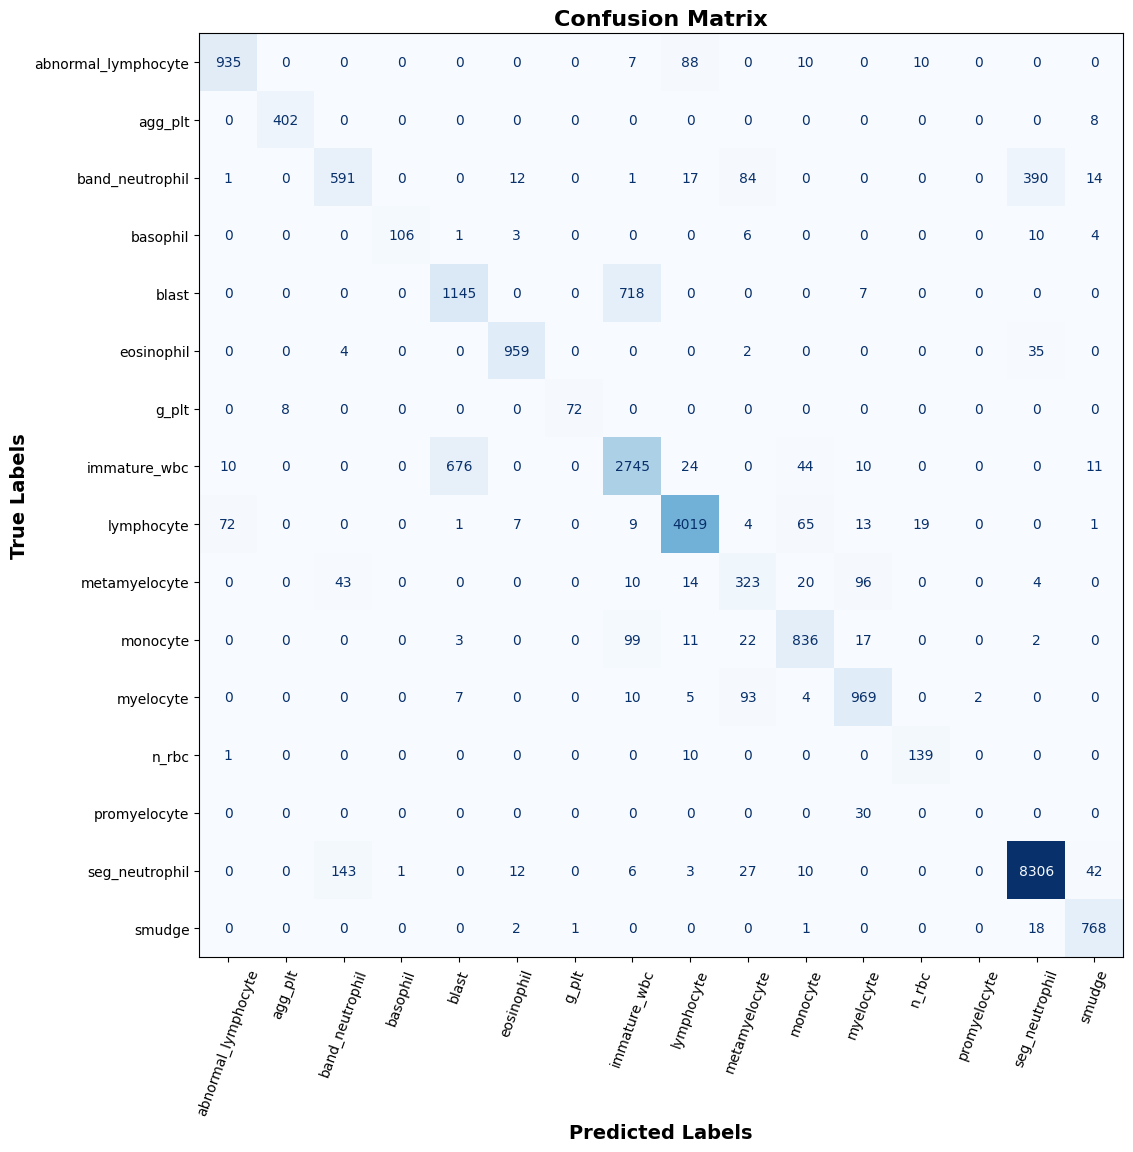

In [17]:
final_cm = sum(CM[:20])  # Sums up elements cm[0] to cm[19]

# Create display labels
class_names = sorted_class
plt.figure(figsize=(12, 12))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
## Rotate x-axis labels
plt.xticks(rotation=70)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=14, fontweight='bold')
plt.ylabel("True Labels", fontsize=14, fontweight='bold')

#plt.tight_layout()
plt.savefig('CM_centralized.png') 
plt.show()

In [15]:
y_true = list(chain.from_iterable(Y))
y_gt = list(chain.from_iterable(Pred))

In [16]:
# Print classification report
report = classification_report(y_true, y_gt, target_names=[f"Class {i}" for i in range(16)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.89      0.90      1050
     Class 1       0.98      0.98      0.98       410
     Class 2       0.76      0.53      0.63      1110
     Class 3       0.99      0.82      0.89       130
     Class 4       0.62      0.61      0.62      1870
     Class 5       0.96      0.96      0.96      1000
     Class 6       0.99      0.90      0.94        80
     Class 7       0.76      0.78      0.77      3520
     Class 8       0.96      0.95      0.96      4210
     Class 9       0.58      0.63      0.60       510
    Class 10       0.84      0.84      0.84       990
    Class 11       0.85      0.89      0.87      1090
    Class 12       0.83      0.93      0.87       150
    Class 13       0.00      0.00      0.00        30
    Class 14       0.95      0.97      0.96      8550
    Class 15       0.91      0.97      0.94       790

    accuracy                           0.88     25490
  

In [63]:
chunk = 9
best_model.evaluate(x_test_chunk[chunk], y_test_encoded_chunk[chunk], batch_size=40, verbose=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9704 - loss: 0.1134


[0.20860594511032104, 0.9529227018356323]

In [62]:
y_pred = best_model.predict(x_test_chunk[9], batch_size=20,  verbose=1)

128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [59]:
sparse_gt = np.argmax(y_test_encoded_chunk[chunk], axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

print(sparse_gt.shape)
print(sparse_pred.shape)

(2549,)
(2549,)


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

Accuracy: 0.5810121616320125
F1 Score (macro): 0.19237169640395446
F1 Score (micro): 0.5810121616320125
Recall (macro): 0.16690119834916214
Recall (micro): 0.5810121616320125
Precision (macro): 0.23675213675213677
Precision (micro): 0.5810121616320125


Confusion Matrix:


/root/miniconda3/envs/tff/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


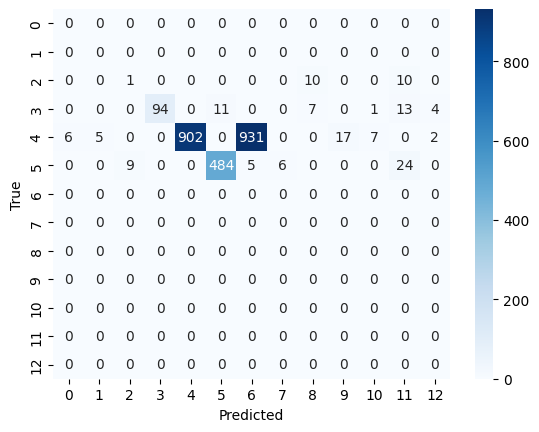

In [60]:
# Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
print("Accuracy:", accuracy)

# F1 Score (macro)
f1_macro = f1_score(sparse_gt, sparse_pred, average='macro')
print("F1 Score (macro):", f1_macro)

# F1 Score (micro)
f1_micro = f1_score(sparse_gt, sparse_pred, average='micro')
print("F1 Score (micro):", f1_micro)

# Recall (macro)
recall_macro = recall_score(sparse_gt, sparse_pred, average='macro')
print("Recall (macro):", recall_macro)

# Recall (micro)
recall_micro = recall_score(sparse_gt, sparse_pred, average='micro')
print("Recall (micro):", recall_micro)

# Precision (macro)
precision_macro = precision_score(sparse_gt, sparse_pred, average='macro')
print("Precision (macro):", precision_macro)

# Precision (micro)
precision_micro = precision_score(sparse_gt, sparse_pred, average='micro')
print("Precision (micro):", precision_micro)

# Confusion Matrix
cm = confusion_matrix(sparse_gt, sparse_pred)
print("\n\nConfusion Matrix:")
#print(cm)
# Visualize the confusion matrix using seaborn
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy is: 70.06669282071401
Sensitivity :  1.0
Specificity :  1.0
PPV :  1.0
NPV :  1.0


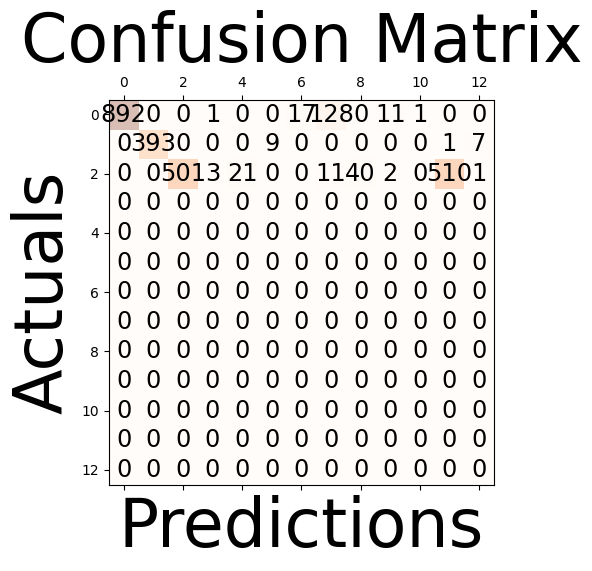

In [31]:
#y_pred = best_model.predict(x=X_test, batch_size = 300)    
a = accuracy_score(sparse_gt, sparse_pred.round())
print('Accuracy is:', a*100)

conf_matrix = confusion_matrix(y_true=sparse_gt, y_pred=sparse_pred.round())

sensitivity1 = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1])
print('Sensitivity : ', sensitivity1 )
specificity1 = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
print('Specificity : ', specificity1)

PPV1 = conf_matrix[1,1]/(conf_matrix[0,1]+conf_matrix[1,1])
print('PPV : ', PPV1 )
NPV1 = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[1,0])
print('NPV : ', NPV1)

# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=48)
plt.ylabel('Actuals', fontsize=48)
plt.title('Confusion Matrix', fontsize=48)
#plt.savefig('C:/Users/Dhruba/Codes/Slice_selection confusion_matrix.tiff', dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [22]:
model.evaluate(x_test, y_test_encoded, batch_size=1, verbose=1)

25490/25490 ━━━━━━━━━━━━━━━━━━━━ 134s 5ms/step - accuracy: 0.7047 - loss: 0.7757


[0.49749448895454407, 0.8391526341438293]

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [ ]:
# class EvaluateCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         loss, accuracy = self.model.evaluate(x_test, y_test_encoded, verbose=1, batch_size=10)
#         print(f'Epoch {epoch+1}: Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}')

In [ ]:
# def dense_block(x, repetitions, filters):
#     for _ in range(repetitions):
#         y = BatchNormalization()(x)
#         y = ReLU()(y)
#         y = Conv2D(4 * filters, 1, padding='same')(y)
#         y = BatchNormalization()(y)
#         y = ReLU()(y)
#         y = Conv2D(filters, 3, padding='same')(y)
#         x = concatenate([y, x])
#     return x

# def transition_layer(x):
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
#     x = AvgPool2D(2, strides=2, padding='same')(x)
#     return x

# def DenseNet121(input_shape=(128, 128, 3), num_classes=16):
#     inputs = Input(input_shape)

#     x = Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPool2D(3, strides=2, padding='same')(x)

#     x = dense_block(x, 6, 32)
#     x = transition_layer(x)
#     x = Dropout(0.1)(x)

#     x = dense_block(x, 12, 32)
#     x = transition_layer(x)
#     x = Dropout(0.1)(x)
    
#     x = dense_block(x, 24, 32)
#     x = transition_layer(x)
#     x = Dropout(0.1)(x)

#     x = dense_block(x, 16, 32)
#     x = Dropout(0.1)(x)

#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     return model

# model = DenseNet121()
# #model.summary()

In [2]:
# def dense_block(x, repetitions, filters):
#     for _ in range(repetitions):
#         y = BatchNormalization()(x)
#         y = ReLU()(y)
#         y = Conv2D(4 * filters, 1, padding='same')(y)
#         y = BatchNormalization()(y)
#         y = ReLU()(y)
#         y = Conv2D(filters, 3, padding='same')(y)
#         x = concatenate([y, x])
#     return x

# def transition_layer(x):
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
#     x = AvgPool2D(2, strides=2, padding='same')(x)
#     return x

# def DenseNet121(input_shape=(128, 128, 3), num_classes=16):
#     inputs = Input(input_shape)

#     x = Conv2D(64, 7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPool2D(3, strides=2, padding='same')(x)

#     x = dense_block(x, 6, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 12, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 24, 32)
#     x = transition_layer(x)

#     x = dense_block(x, 16, 32)

#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs, outputs)
#     return model

# model = DenseNet121()
# model.summary()

I0000 00:00:1732459688.917243   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.106123   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.106217   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.118654   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732459689.118722   22897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:47:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "WBC_Classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,207,056 (4.60 MB)

 Trainable params: 1,204,368 (4.59 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [6]:
# def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
#     if conv_shortcut:
#         shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
#         shortcut = BatchNormalization()(shortcut)
#     else:
#         shortcut = x

#     x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)

#     x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)

#     x = Add()([shortcut, x])
#     x = ReLU()(x)

#     return x
    
# def resnet_34(input_shape=(128, 128, 3), num_classes=16):
#     inputs = Input(shape=input_shape)

#     # Initial Conv
#     x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

#     # Residual blocks
#     for size in [64, 128, 256, 512]:
#         strides = 1 if size == 64 else 2
#         x = residual_block(x, size, stride=strides)
#         for _ in range(1, (34-2)//6 if size == 64 else 2):
#             x = residual_block(x, size, conv_shortcut=False)

#     # Global Average Pooling and Fully Connected Layer
#     x = GlobalAveragePooling2D()(x)
#     outputs = Dense(num_classes, activation='softmax')(x)

#     return tf.keras.models.Model(inputs=inputs, outputs=outputs)

# model = resnet_34()
#model.summary()

In [7]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    # 1x1 convolution
    conv1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    # 5x5 convolution
    conv5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    # Max pooling followed by 1x1 convolution
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate all the branches
    output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=-1, name=name)
    return output

def build_inception_v1(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Initial layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32, name='inception_3a')
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name='inception_3b')
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64, name='inception_4a')
    x = inception_module(x, 160, 112, 224, 24, 64, 64, name='inception_4b')
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name='inception_4c')
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name='inception_4d')
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_4e')
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_5a')
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name='inception_5b')

    # Global average pooling and dropout
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)

    # Fully connected layer (output layer)
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(input_layer, output_layer, name='InceptionV1')
    return model

# Example usage
input_shape = (128, 128, 3)  # Image size
num_classes = 16  # Number of classes
model = build_inception_v1(input_shape, num_classes)

# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "InceptionV1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │    110,784 │ conv2d_28[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 16, 16,    │     18,528 │ max_pooling2d_2[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 16, 16,    │      3,088 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 16, 16,    │     12,352 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 16, 16,    │    110,720 │ conv2d_31[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 16, 16,    │     12,832 │ conv2d_33[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 16, 16,    │      6,176 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a        │ (None, 16, 16,    │          0 │ conv2d_30[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_32[0][0],  │
│                     │                   │            │ conv2d_34[0][0],  │
│                     │                   │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16,    │     32,896 │ inception_3a[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 16, 16,    │      8,224 │ inception_3a[0][… │
│                     │ 32)               │            │                 

 Total params: 5,989,952 (22.85 MB)

 Trainable params: 5,989,952 (22.85 MB)

 Non-trainable params: 0 (0.00 B)